In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
from IPython.display import display
from torch.utils.data import DataLoader
from src.datasets.dataset_builder import RawDataLoader, BuildDataset
from src.datasets.dataset import DatasetUtils, Scaler, NFLPredictOnlyDataset

from src.models.PlayerTracker import PlayerTrackerTransformer

from src.training.trainer import Trainer
from src.training.trainer_config import TrainConfig

from src.utils.plotting import Plotter
from src.utils.evals import Evaluator, EvaluatorUtils
import pickle


/Users/christopherquintas/miniconda3/envs/NFL_bigdatabowl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load in Raw Data from Kaggle

In [3]:
DATA_DIR = './data/train'
df_inputs, df_outputs = RawDataLoader.load_raw_data_from_csv(DATA_DIR)

Loaded 18 input files and 18 output files.


### Build Dataset from Raw Data

In [ ]:
player_sequences = BuildDataset.build_sequences(df_inputs, df_outputs, max_out_frames=100, export_dir="./data/processed/train/", export_split=False)
#RawDataLoader.save_sequences_to_pickle(player_sequences, "./data/processed/train/objects/player_sequences.pkl")

#### Build Dataset from Processed CSVs
* predict - only include entries for the players you will be predicting

In [ ]:
samples_csv   = "./data/processed/train/samples.csv"
sequences_csv = "./data/processed/train/all_sequences.csv"

player_sequences_predict = RawDataLoader.load_processed_data_from_csv(samples_csv, sequences_csv, T_out=100, only_predict=True)
RawDataLoader.save_sequences_to_pickle(player_sequences_predict, "./data/processed/train/objects/player_sequences_predict.pkl")

# player_sequences_all = RawDataLoader.load_processed_data_from_csv(samples_csv, sequences_csv, T_out=100, only_predict=False)
# RawDataLoader.save_sequences_to_pickle(player_sequences_all, "./data/processed/train/objects/player_sequences_all.pkl")

### Load Serialized Dataset

In [4]:
player_sequences = RawDataLoader.load_sequences_from_pickle("./data/processed/train/objects/player_sequences_predict.pkl")

Loaded 46045 sequences from ./data/processed/train/objects/player_sequences_predict.pkl


### DataLoader Construction

In [5]:
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
BATCH_SIZE = 32

In [ ]:
train_player_sequences, test_player_sequences = DatasetUtils.train_test_split(player_sequences, train_split=0.8, seed=1)
scaler = Scaler()
train_dataset = NFLPredictOnlyDataset(train_player_sequences, scaler, fit_scaler=True)
validation_dataset  = NFLPredictOnlyDataset(test_player_sequences, scaler, fit_scaler=False)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=NFLPredictOnlyDataset.collate_predict_only)
validation_dataloader  = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=NFLPredictOnlyDataset.collate_predict_only)

### Training Configuration

In [7]:
LEARNING_RATE = 1e-4
EPOCHS = 200

In [ ]:
feature_dim = train_dataset[0]['hist'].shape[-1]
max_predicts = 100

model = PlayerTrackerTransformer(d_in=feature_dim, T_out=max_predicts).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss(reduction="none") # want custom mean

In [9]:
config = TrainConfig()
config.learning_rate = LEARNING_RATE
config.batch_size = BATCH_SIZE
config.num_epochs = EPOCHS
config.device = DEVICE
config.checkpoint = True

### Train Model

In [ ]:
trainer = Trainer(config, optimizer, criterion, run_desc="Full_Train")
trainer.fit(model, train_dataloader, validation_dataloader)

### Load Model

In [10]:
ckpt = torch.load('./model_registry/best_model_train.pt', map_location=DEVICE)["model_state"]

model = PlayerTrackerTransformer(d_in=11, T_out=100)

model.load_state_dict(ckpt)
model.to(DEVICE)
model.eval() 
print(1)

1


/Users/christopherquintas/miniconda3/envs/NFL_bigdatabowl/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


### Evaluate Model

In [11]:
xl = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=NFLPredictOnlyDataset.collate_predict_only)

In [12]:
model.to(DEVICE).eval()
hist, padded_frame_mask, last_known_xy, target_xy, meta = next(iter(xl))

META: {'gid': [2023123112], 'pid': [2276], 'nfl_id': [52423], 'target_mask': tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True]]), 'target_lengths': tensor([14])}
PREDS: tensor([[[49.9903, 22.7623],
         [50.3588, 22.1238],
         [50.7568, 21.4565],
         [51.1567, 20.7144],
         [51.5082, 19.9940],
         [51.8797, 19.2634],
         [52.2342, 18.5824],
         [52.5623, 17.8894],
         [52.8919, 17.1634],
         [53.2339, 16.4218],
         [53.5446, 15.7126],
         [53.8580, 14.9451],
         [54.1755, 14.2745],
         [54.4766, 13.6125]]], device='mps:0', grad_fn=<SliceBackward0>)
TARGET: tensor([[[50.0800, 22.6900],
         [50.5500, 22.0100],
         [51.0000, 21.3100],
         [51.4200, 20.5800],
         [51.8100, 19.8500],
         [52.1800, 19.1100],
         [52.5400, 18.3800],
         [52.8700, 17.6600],
         [53.1900, 16.9700],
         [53.5100, 16.3200],
         [53.8100, 15.7100],
  

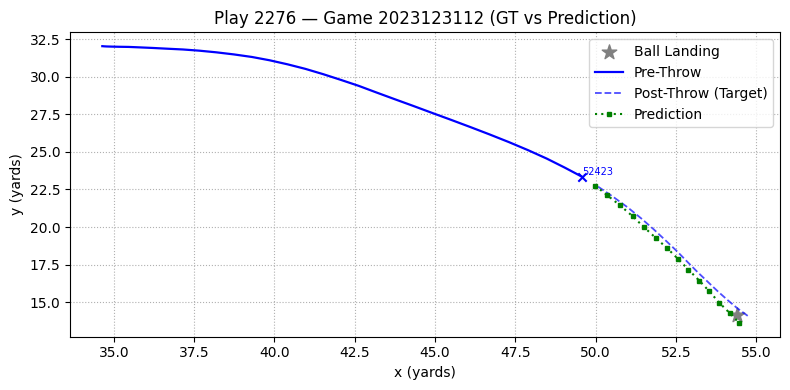

In [17]:
hist, padded_frame_mask, last_known_xy, target_xy = hist.to(DEVICE), padded_frame_mask.to(DEVICE), last_known_xy.to(DEVICE), target_xy.to(DEVICE)

preds = model(hist, padded_frame_mask, last_known_xy)
T_use = target_xy.size(1)
preds = preds[:, :T_use, :] 
print(f"META: {meta}\nPREDS: {preds}\nTARGET: {target_xy}")

GAME_ID, PLAY_ID, NFL_ID = meta['gid'][0], meta['pid'][0], meta['nfl_id'][0]

preds_dict = Evaluator.predict_play_trajectories(model, scaler, seqs=train_dataset, game_id=GAME_ID, play_id=PLAY_ID, device=DEVICE)

sequences_predict_csv = "./data/processed/train/sequences_predict.csv"
sequences_non_predict_csv = "./data/processed/train/sequences_non_predict.csv"
df_pred, df_npred = pd.read_csv(sequences_predict_csv), pd.read_csv(sequences_non_predict_csv)

Plotter.plot_single_player_with_pred(
    df_pred, df_npred,
    preds=preds,
    game_id=GAME_ID, play_id=PLAY_ID, nfl_id=NFL_ID,
    preds_dict=preds_dict,
    save_fig_path = './images/predict_plot.png'
)